In [1]:
from sklearn.metrics import pairwise_distances
import pickle
from scipy import sparse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Normalizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
nba_stats2021 = pd.read_csv('./nba_stats2021_original.csv')
nba_stats2021.head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%FTA,%OREB,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS
0,Stephen Curry,GSW,33,58,32,26,34.1,31.5,10.3,21.3,...,37.9,8.0,17.9,27.6,29.8,20.8,32.5,12.1,32.1,37.1
1,Bradley Beal,WAS,27,57,29,28,35.6,31.1,11.1,22.8,...,37.0,15.9,14.3,22.9,29.6,20.1,26.5,14.3,32.3,34.9
2,Joel Embiid,PHI,27,47,36,11,31.5,29.1,9.2,18.0,...,58.3,43.3,37.2,18.4,34.7,16.1,35.0,21.5,53.0,37.1
3,Luka Doncic,DAL,22,59,35,24,35.1,28.5,10.1,20.8,...,45.4,12.5,25.6,52.4,49.9,21.3,32.2,16.8,38.5,33.7
4,Damian Lillard,POR,30,61,34,27,35.7,28.4,8.8,20.0,...,43.6,6.0,12.8,46.2,36.6,18.0,29.1,11.5,43.1,32.0


In [3]:
# List of stats that describe pure or shooting offensive performance
pure_off = ['3P%','AST%','eFG%','%PTS2PT','%PTSOffTO','%PTSFT','%PTSFBPs','%PTSPITP','2FGM%AST','3FGM%AST','2FGM%UAST']

In [10]:
X = nba_stats2021[pure_off]
y = nba_stats2021['Player']

nn = Normalizer()
X_nn = nn.fit_transform(X)

#creating clusters
pure = KMeans(n_clusters = 3 ,random_state = 42)
pure.fit(X_nn)
y_kmeans = pure.predict(X_nn)
nba_stats2021['pure_kmean'] = pure.labels_
pure_sil = silhouette_score(X_nn, pure.labels_)
print(silhouette_score(X_nn, pure.labels_))

pure_cluster0 = nba_stats2021[nba_stats2021['pure_kmean']==0]
pure_cluster1 = nba_stats2021[nba_stats2021['pure_kmean']==1]
pure_cluster2 = nba_stats2021[nba_stats2021['pure_kmean']==2]

0.3201313863942802


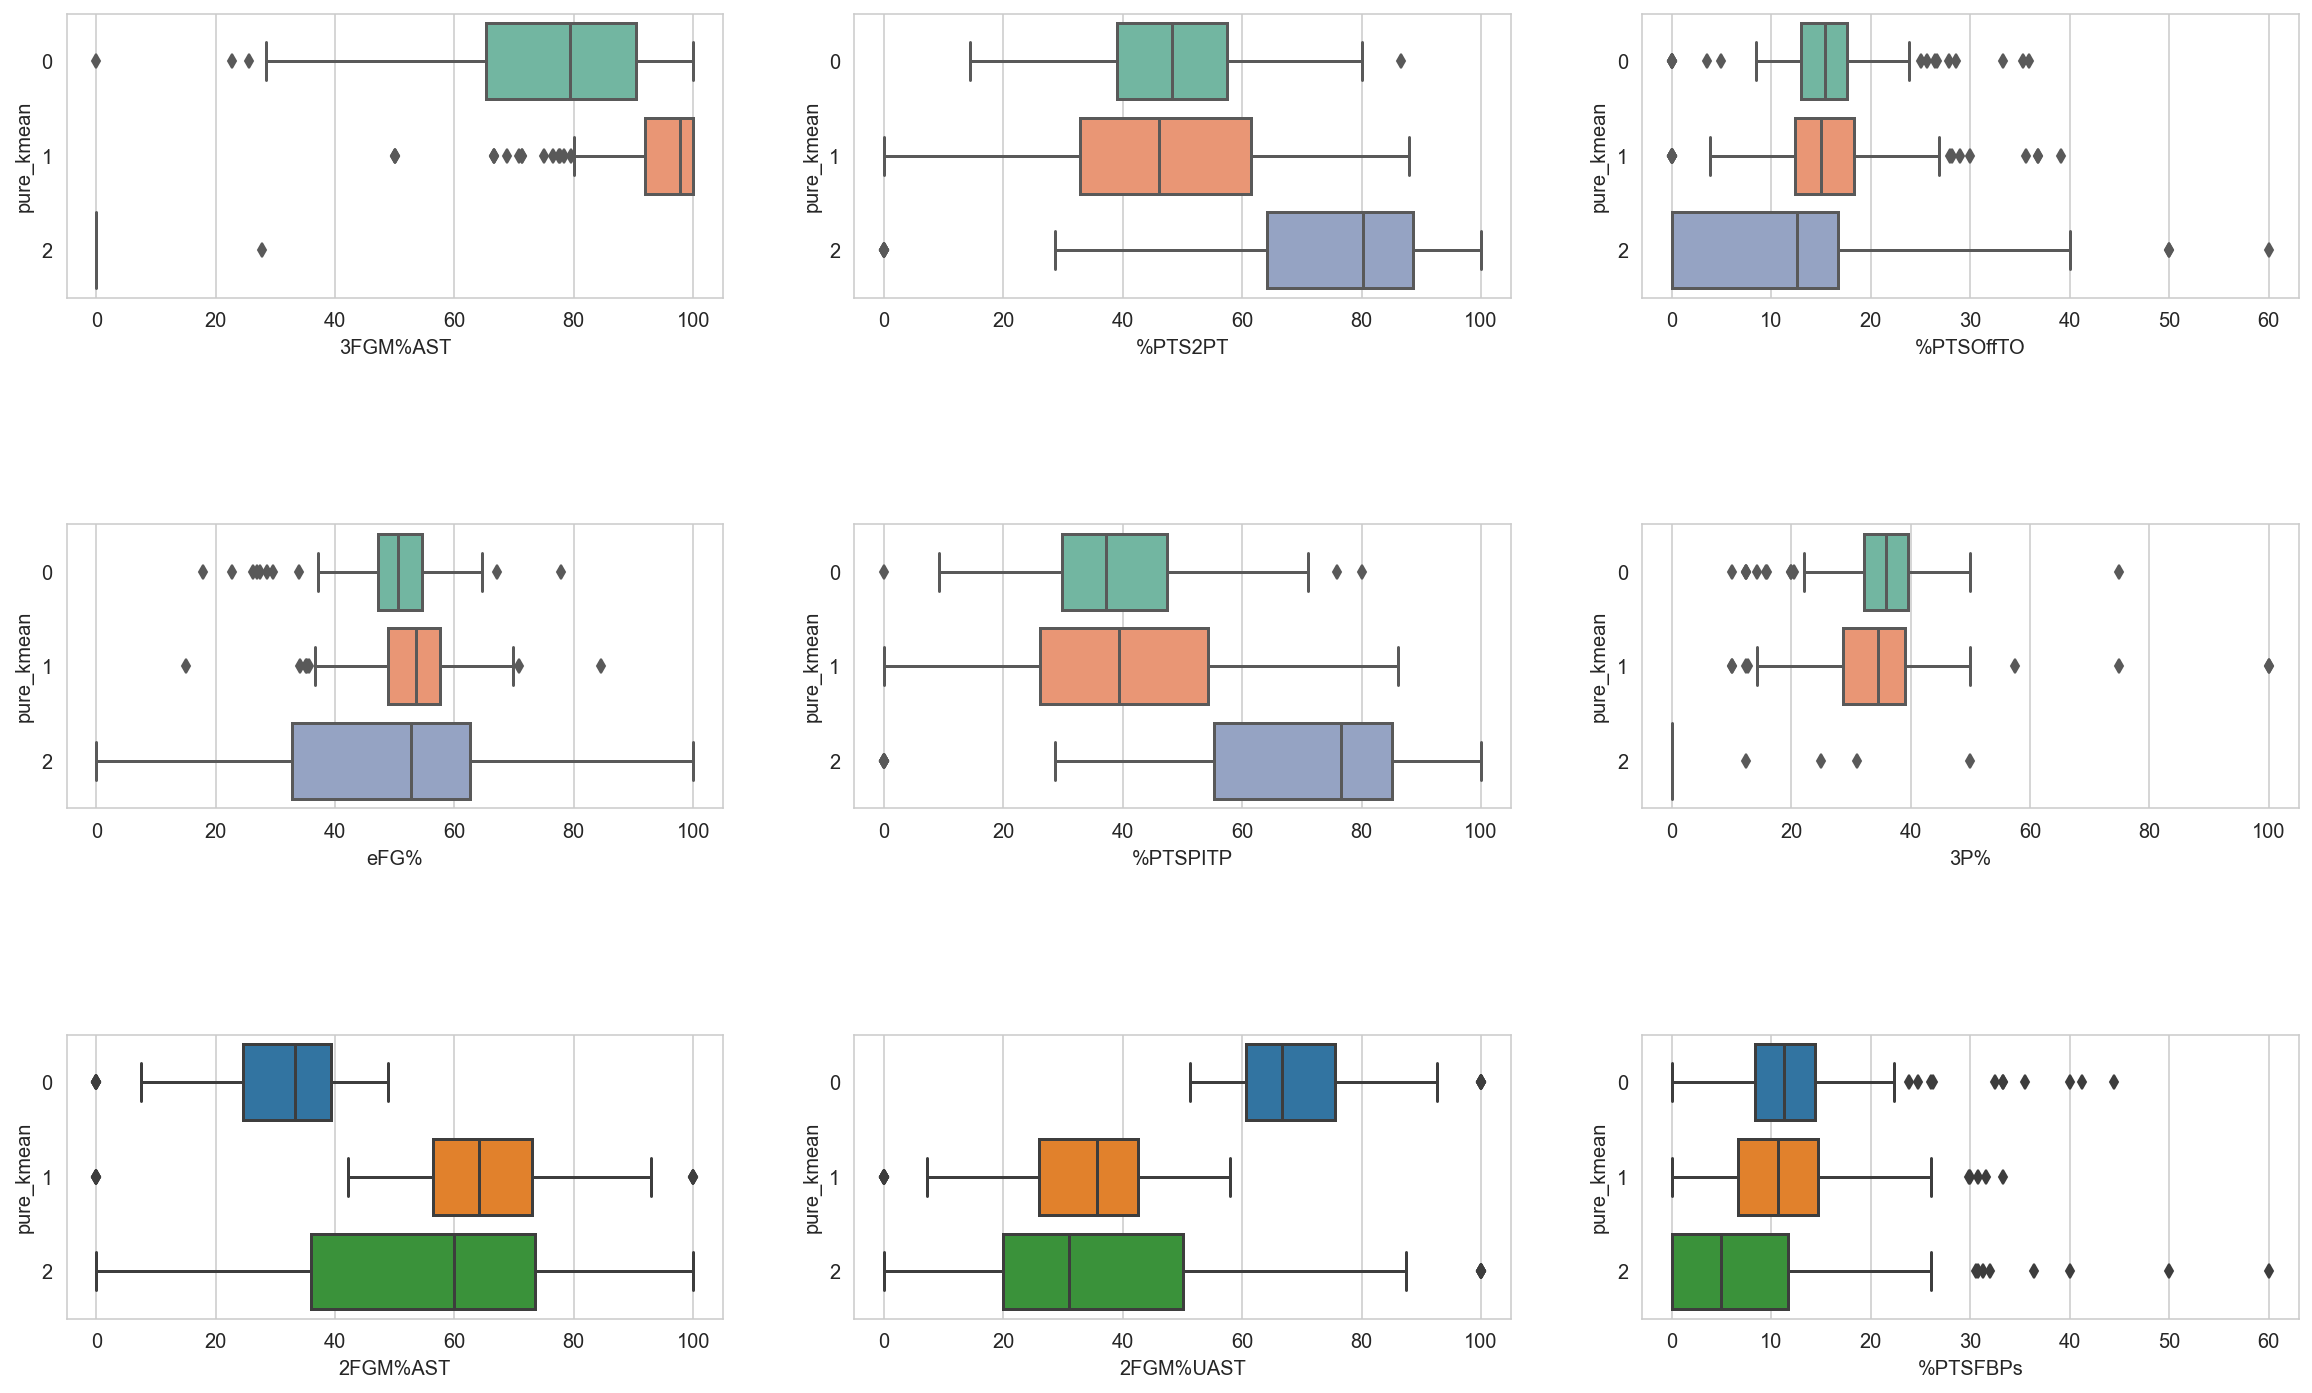

In [23]:
fig, axes = plt.subplots(3, 3, figsize = (20, 12))
plt.subplots_adjust(hspace = 0.8)

# Players who score everywhere
sns.boxplot(x = '3FGM%AST', y = 'pure_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[0,0])
sns.boxplot(x = '%PTS2PT', y = 'pure_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[0,1])
sns.boxplot(x = '%PTSOffTO', y = 'pure_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[0,2])
#---------------------- line 2
# Players who can score better in the paint
sns.boxplot(x = 'eFG%', y = 'pure_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[1,0])
sns.boxplot(x = '%PTSPITP', y = 'pure_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[1,1])
sns.boxplot(x = '3P%', y = 'pure_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[1,2])
#---------------------- LINE 3
# players who can score 2 pointers better
sns.boxplot(x = '2FGM%AST', y = 'pure_kmean', data = nba_stats2021, orient="h", ax = axes[2,0])
sns.boxplot(x = '2FGM%UAST', y = 'pure_kmean', data = nba_stats2021, orient="h", ax = axes[2,1])
sns.boxplot(x = '%PTSFBPs', y = 'pure_kmean', data = nba_stats2021, orient="h", ax = axes[2,2]);

In [15]:
from sklearn.metrics import pairwise_distances
import pickle
from scipy import sparse

In [18]:
# Creating Pivot table
pure_piv = pd.pivot_table(nba_stats2021[pure_off], index = nba_stats2021['Player'])

# Create sparse matrix
pure_sparse = sparse.csr_matrix(pure_piv.fillna(0))

# Calculating Cosine similarity
pure_recommend = pairwise_distances(pure_sparse, metric='cosine')

# Creating Recommender Dataframe
pure_rec_df = pd.DataFrame(pure_recommend, columns=pure_piv.index, index = pure_piv.index)

In [19]:
pickle.dump(pure_rec_df, open('pickle models/pure_k_stat.p', 'wb'))

In [21]:
players = pure_rec_df['LeBron James'].sort_values()[1:4].index
players

Index(['Jrue Holiday', 'Ja Morant', 'Kyrie Irving'], dtype='object', name='Player')

## ```Modern Player Reclassification```
---

In [50]:
pure_cluster0.sort_values(by='%PTSPITP', ascending=False).head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS,trad_kmean,pure_kmean
501,Adam Mokoka,CHI,22,13,3,10,4.1,1.2,0.5,1.4,...,11.9,23.8,15.4,14.3,0.0,35.7,4.0,15.3,3,0
91,Ben Simmons,PHI,24,54,40,14,32.5,14.4,5.6,10.1,...,24.1,40.7,31.4,24.9,29.6,22.6,31.0,18.3,3,0
225,T.J. McConnell,IND,29,62,29,33,25.5,8.2,3.8,6.8,...,16.1,44.2,25.9,37.7,15.6,14.8,10.2,13.3,3,0
156,Elfrid Payton,NYK,27,57,32,25,24.5,11.0,4.6,10.5,...,15.1,29.8,24.8,23.2,38.7,17.9,21.8,20.3,3,0
461,Jeremiah Martin,CLE,24,4,0,4,5.6,2.3,1.0,2.8,...,11.1,16.7,37.5,66.7,0.0,16.7,20.0,20.0,3,0


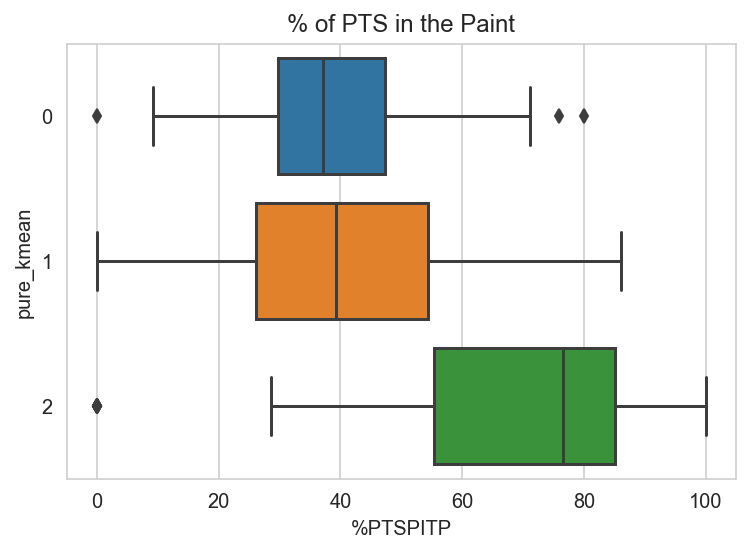

In [49]:
plt.title('% of PTS in the Paint')
sns.boxplot(x = '%PTSPITP', y = 'pure_kmean', data = nba_stats2021, orient="h");

In [25]:
pure_cluster0.sort_values(by='2FGM%UAST', ascending=False).head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS,trad_kmean,pure_kmean
523,Ty-Shon Alexander,PHX,22,13,9,4,3.1,0.5,0.2,0.8,...,15.0,21.1,22.2,0.0,0.0,20.0,5.0,7.1,3,0
506,Karim Mane,ORL,20,10,2,8,8.8,1.1,0.3,1.3,...,17.9,12.9,13.0,0.0,41.2,30.3,7.9,6.0,3,0
442,Frank Ntilikina,NYK,22,27,19,8,10.0,2.7,0.9,2.5,...,10.3,15.6,12.7,33.3,11.1,29.7,12.9,13.2,3,0
504,Sindarius Thornwell,ORL,26,15,7,8,6.3,1.1,0.5,1.7,...,7.2,14.7,14.8,43.8,11.1,16.0,5.4,8.5,3,0
497,Jontay Porter,MEM,21,9,5,4,3.0,1.2,0.3,1.1,...,31.3,20.0,50.0,28.6,0.0,54.5,14.3,27.5,3,0


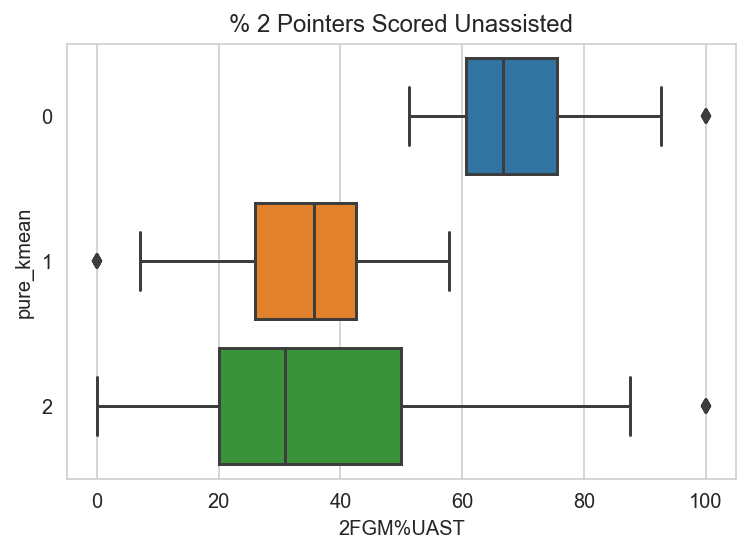

In [46]:
plt.title('% 2 Pointers Scored Unassisted')
sns.boxplot(x = '2FGM%UAST', y = 'pure_kmean', data = nba_stats2021, orient="h");

In [26]:
pure_cluster0.sort_values(by='2FGM%AST', ascending=False).head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS,trad_kmean,pure_kmean
12,Nikola Jokic,DEN,26,66,44,22,35.0,26.4,10.2,18.1,...,34.3,41.0,33.9,24.6,27.9,21.8,40.2,30.9,0,0
125,Will Barton,DEN,30,56,37,19,31.0,12.7,4.6,10.9,...,14.2,18.0,20.8,18.1,21.9,16.0,14.9,17.0,0,0
6,Kevin Durant,BKN,32,29,18,11,33.1,28.3,9.8,17.9,...,22.2,26.6,35.2,17.1,25.5,16.4,39.0,32.5,3,0
55,Andrew Wiggins,GSW,26,66,33,33,33.3,18.3,6.9,14.7,...,15.9,12.7,16.8,17.0,19.6,15.1,22.9,23.6,0,0
20,Jaylen Brown,BOS,24,58,30,28,34.5,24.7,9.3,19.2,...,18.7,19.5,26.4,22.9,30.4,19.3,28.3,30.2,3,0


In [28]:
pure_cluster0['2FGM%UAST'].mean()

69.95808383233536

In [52]:
pure_cluster0.sort_values(by='%PTSOffTO', ascending=False).head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS,trad_kmean,pure_kmean
467,Sean McDermott,MEM,24,18,10,8,8.8,2.2,0.7,1.8,...,12.5,7.0,7.0,5.4,8.0,18.2,6.7,12.8,3,0
504,Sindarius Thornwell,ORL,26,15,7,8,6.3,1.1,0.5,1.7,...,7.2,14.7,14.8,43.8,11.1,16.0,5.4,8.5,3,0
501,Adam Mokoka,CHI,22,13,3,10,4.1,1.2,0.5,1.4,...,11.9,23.8,15.4,14.3,0.0,35.7,4.0,15.3,3,0
441,Kelan Martin,IND,25,28,12,16,6.5,2.8,1.1,2.6,...,23.8,12.6,17.9,15.0,20.0,24.7,13.2,17.8,3,0
439,Tremont Waters,BOS,23,22,12,10,7.5,2.8,0.9,2.4,...,8.2,58.8,30.2,43.3,18.8,15.7,15.4,16.2,3,0


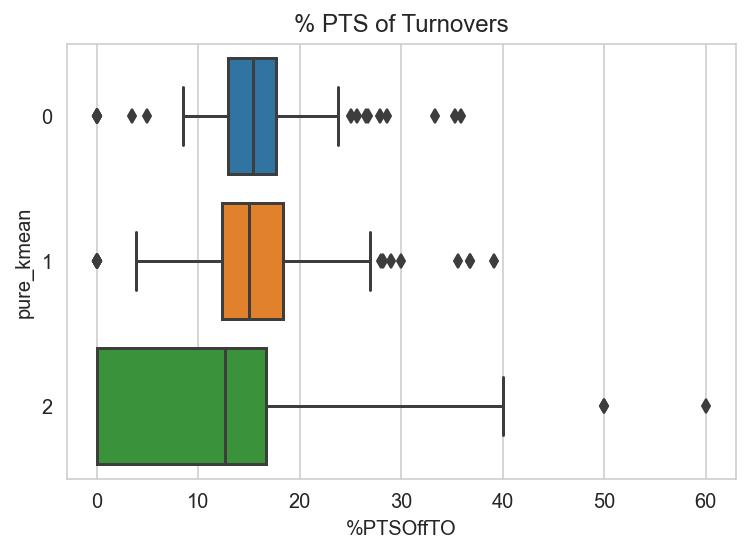

In [53]:
plt.title('% PTS of Turnovers')
sns.boxplot(x = '%PTSOffTO', y = 'pure_kmean', data = nba_stats2021, orient="h");

In [51]:
pure_cluster0['%PTSOffTO'].mean()

15.36347305389222

In [39]:
pure_cluster1.sort_values(by='2FGM%AST', ascending=False).head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS,trad_kmean,pure_kmean
451,Jalen Harris,TOR,22,8,3,5,5.7,2.5,0.9,1.9,...,15.0,16.1,37.5,23.1,33.3,25.0,0.0,16.3,0,1
507,Deividas Sirvydis,DET,20,16,8,8,3.0,1.1,0.3,1.1,...,22.4,11.1,23.1,16.7,12.5,18.2,8.3,17.3,0,1
472,James Nunnally,NOP,30,6,3,3,6.1,2.0,0.7,1.7,...,16.3,13.3,11.1,0.0,0.0,11.1,10.0,15.0,0,1
477,Elijah Hughes,UTA,23,17,14,3,3.6,1.8,0.6,1.8,...,13.5,20.0,26.1,12.5,16.7,2.9,40.0,25.6,0,1
361,Mychal Mulder,GSW,26,54,27,27,11.8,4.9,1.7,3.9,...,9.8,5.5,8.4,9.7,6.6,17.0,7.5,16.9,0,1


In [34]:
pure_cluster1['eFG%'].mean()

53.122680412371125

In [43]:
pure_cluster2.sort_values(by='PTS', ascending=False).head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS,trad_kmean,pure_kmean
5,Giannis Antetokounmpo,MIL,26,56,36,20,33.1,28.4,10.3,18.3,...,33.5,33.2,37.3,21.1,35.1,23.3,55.8,34.0,1,2
77,Andre Drummond,LAL,27,39,14,25,27.5,15.6,6.4,13.1,...,50.1,15.8,31.3,31.1,46.9,28.3,36.3,26.0,1,2
81,T.J. Warren,IND,27,4,3,1,29.3,15.5,6.8,12.8,...,14.0,7.6,12.9,9.5,12.5,28.6,27.3,22.5,1,2
84,Clint Capela,ATL,26,59,31,28,30.1,15.3,6.6,11.1,...,47.3,5.2,14.0,16.7,25.4,21.1,21.7,21.6,1,2
94,Rudy Gobert,UTA,28,65,48,17,30.8,14.4,5.5,8.2,...,42.2,8.1,19.1,13.9,26.9,21.5,36.8,18.9,1,2


In [42]:
pure_cluster2['%PTS2PT'].mean()

70.51447368421051